In [1]:
# Kristina Fauss
# April 19, 2024
# model selection by AIC testing all 1st order interactions

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.stats.multitest import multipletests

from ols_mixedef_custom import *

In [2]:
fp = '/Users/kristinafauss/BackupToBox/Git/lab-flammability-testing-2022/data/processed-data/main_dataset.csv'

flamog = pd.read_csv(fp)

# drop na's for flam metrics
print(len(flamog))
for col in ['fh', 'fd', 'pfg', 'temp_change', 'heat_flux_change']:
    flamog.dropna(subset=col, inplace=True)
print(len(flamog))

flamog['plant_id']=[str(a)+'_'+str(b) for a,b in zip(flamog['plant'], flamog['species'])]

# drop hetarb - only 2 data points
flamog = flamog[flamog.species!='HETARB']

# make mpa negative
flamog['mpa'] = flamog.mpa *-1

# report
print(flamog.columns)
flamog.head()

172
171
Index(['Unnamed: 0', 'species', 'plant', 'date', 'total_branch_mass',
       'total_leaf_mass', 'stem_mass_ratio', 'leaf_mass_ratio', 'leaf_lfm',
       'thickness', 'leaf_wet_mass', 'leaf_dry_mass', 'stem_lfm', 'stem_width',
       'stem_wet_mass', 'stem_dry_mass', 'stem_sav', 'lfm', 'leaf_dmc',
       'stem_dmc', 'dmc', 'leaf_area', 'leaf_sav', 'LMA', 'SLA', 'rep',
       'branch_length', 'branch_width', 'branch_height', 'sample_wt',
       'no_branches', 'mpa', 'notes_on_plant_char', 'start_time',
       'ambient_temp', 'ambient_humidity', 'pre_ignition_glow',
       'first_glow_time', 'ignition', 'primary_ignition',
       'primary_time_of_flame_end', 'secondary_ignition',
       'secondary_time_of_flame_end', 'third_ignition',
       'third_time_of_ignition_flame_end', 'time_fh', 'fh', 'time_of_glow_end',
       'end_time', 'thermocoupler_height', 'hotplate_height',
       'notes_on_flam_data', 'fd', 'tti', 'pfg', 'max_temp',
       'time_at_max_temp', 'max_temp_sensor', '

,Unnamed: 0,species,plant,date,total_branch_mass,total_leaf_mass,stem_mass_ratio,leaf_mass_ratio,leaf_lfm,thickness,...,wet_mass,dry_mass,gdw_gfw,dw_flam_sample,ww_flam_sample,branch_volume,branching,sample_density,dw_sppdev,plant_id
0,1,ARCDEN,1,2022-08-10,20.347,19.505,0.510564,0.489436,251.06912,0.514,...,1.151,0.3683,0.242414,1.291195,4.035205,1082.04,0.416667,0.004923,0.923122,1_ARCDEN
1,2,ARCDEN,1,2022-08-10,20.347,19.505,0.510564,0.489436,251.06912,0.514,...,1.151,0.3683,0.242414,1.429372,4.467028,1370.20,0.322581,0.004303,1.348152,1_ARCDEN
2,3,ARCDEN,1,2022-08-10,20.347,19.505,0.510564,0.489436,251.06912,0.514,...,1.151,0.3683,0.242414,1.283923,4.012477,682.04,0.294118,0.007766,0.900752,1_ARCDEN
3,4,ARCDEN,1,2022-08-10,20.347,19.505,0.510564,0.489436,251.06912,0.514,...,1.151,0.3683,0.242414,1.283923,4.012477,1262.25,0.466667,0.004196,0.900752,1_ARCDEN
4,5,ARCDEN,1,2022-08-10,20.347,19.505,0.510564,0.489436,251.06912,0.514,...,1.151,0.3683,0.242414,0.811215,2.535185,819.00,0.500000,0.004086,-0.553297,1_ARCDEN


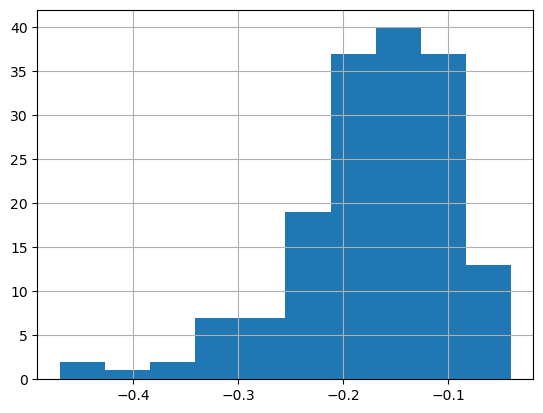

In [3]:
#mpa should be negative
flamog.mpa.hist();

In [4]:
flamog.species.value_counts()

species
ERIKAR    37
SALLEU    36
CEAGRI    29
SALAPI    22
MALLAU    20
ARTCAL    13
ARCDEN     8
Name: count, dtype: int64

# Examine Correlation & Structure in Num. Var's

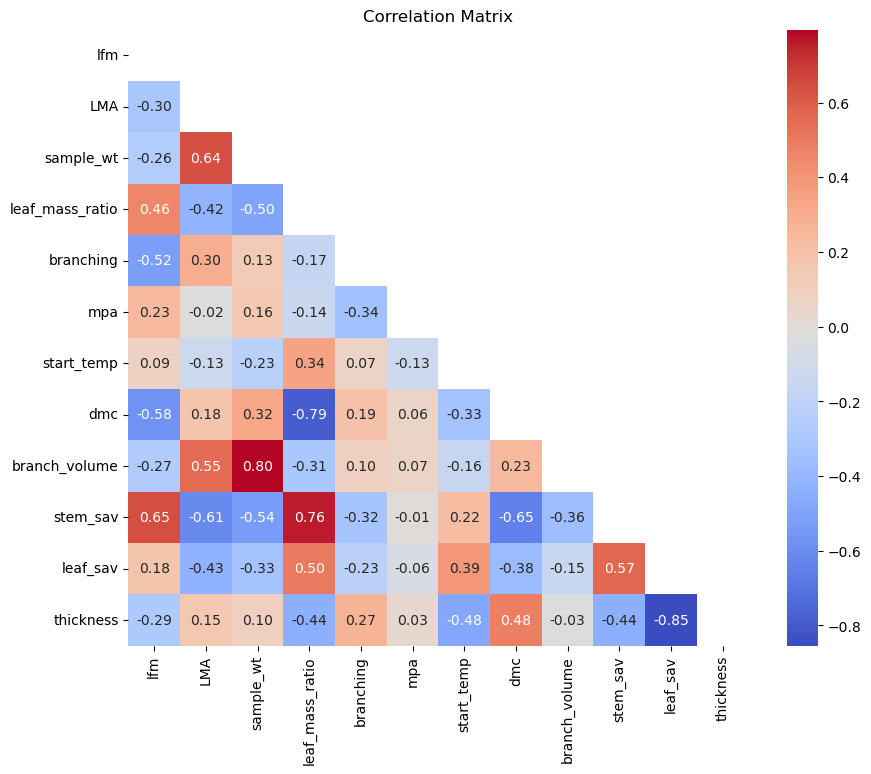

In [5]:
cols_num_use = ['lfm', 'LMA', 'sample_wt', 'leaf_mass_ratio', 'branching', 'mpa', 'start_temp', 'dmc', 'branch_volume', 'stem_sav', 'leaf_sav', 'thickness']

corrplot(flamog, cols_num_use)

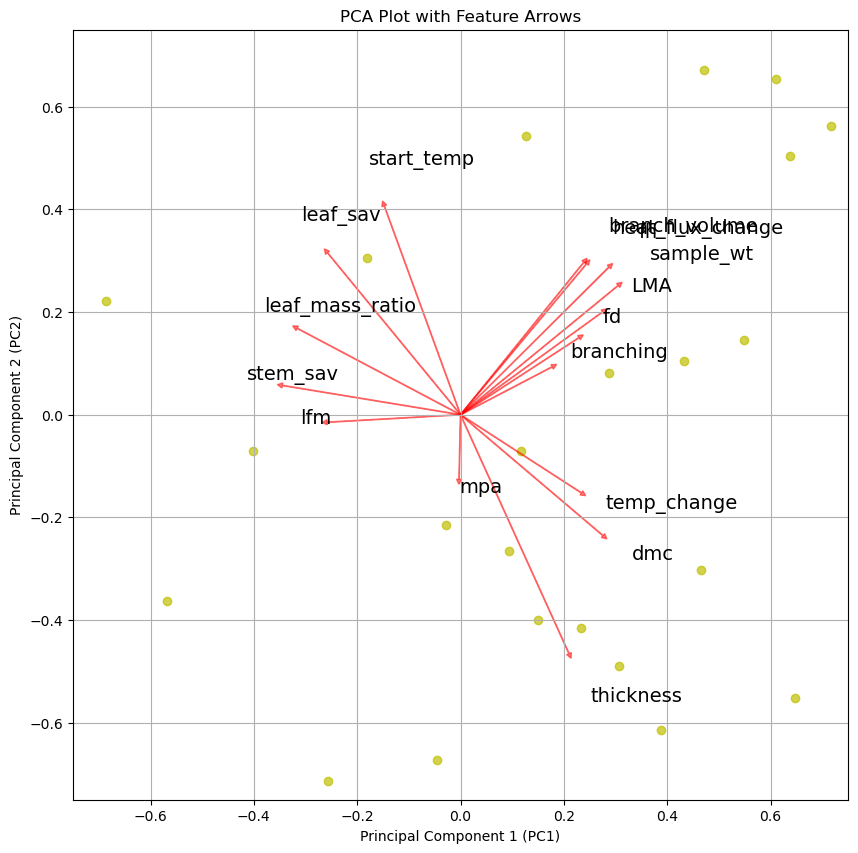

In [6]:
PCAplot(flamog, cols_num_use+['fh','fd','temp_change','heat_flux_change'])

# Modeling Preprocessing

In [7]:
# scale and center
cols_all = ['fh', 'fd', 'temp_change', 'heat_flux_change'] + cols_num_use
flam = scale_and_center(flamog, cols_all, cols_no_change=['plant_id', 'species', 'ignition'])

# declare as factors
flam['species'] = pd.Categorical(flam['species'])
flam['plant_id'] = pd.Categorical(flam['plant_id'])
flam['ignition'] = pd.Categorical(flam['ignition'])

# drop na's
print(len(flam))
cols_all_dpna = cols_all + ['plant_id', 'species', 'ignition']
flam.dropna(subset=cols_all_dpna, inplace=True)
print(len(flam))

# declare all possible IV cols to model
cols_use = cols_num_use #+ ['species']
print(cols_use)

165
158
['lfm', 'LMA', 'sample_wt', 'leaf_mass_ratio', 'branching', 'mpa', 'start_temp', 'dmc', 'branch_volume', 'stem_sav', 'leaf_sav', 'thickness']


## FH

In [8]:
y='fh'
df=flam

## examine each variable's LM within species groups

print if near significant

In [9]:
pthresh=0.15

for var in cols_use:
    print('\n\n', var)
    formula = y + '~' + var
    for spec in flam.species.unique():
        flami=flam[flam.species==spec]
        model = smf.ols(formula, data=flami)
        results = model.fit(reml=False)
        if results.pvalues[1] < pthresh:
            print(spec)
            print(results.params[1], results.pvalues[1])
            #sns.regplot(x= flami.lfm, y= flami.fh);



 lfm
CEAGRI
0.3457255605980738 0.11011917077797649
ERIKAR
-0.3623459161062251 0.00014913240369672636


 LMA


 sample_wt
ARTCAL
2.5264213934302164 0.050586297196401335
CEAGRI
0.2202339364725167 0.13021488589705865
MALLAU
0.6945016946448713 0.0024566481121215157
SALAPI
0.600805065278571 0.0009589117326533063
SALLEU
0.8797797485146656 0.0014578537686728043


 leaf_mass_ratio
CEAGRI
-0.30298316924068747 0.016311689128986062


 branching
ARCDEN
-0.5015666791807878 0.02403909129023342
ARTCAL
0.32758071460658983 0.02781997227856982
CEAGRI
0.19596147224995267 0.08174697853424004
ERIKAR
0.5737326346517378 0.0032343939424240493
MALLAU
0.5185639598767615 0.11069443537188374
SALAPI
-0.47852042643786086 0.12812315289415907
SALLEU
0.286991871456423 0.027526727495656718


 mpa


 start_temp
ERIKAR
0.5173285690778818 0.0006312126567439317


 dmc
MALLAU
1.0701222171637885 0.07686958796541048


 branch_volume
ERIKAR
0.4179170988385403 0.003224548600677392
MALLAU
0.3496330068480874 0.09911978241266091

## examine each variables significance and ranking by AIC outside in Mixed LM structure
(tests each independently and reports together)

In [10]:
yvar=y
cols=cols_use
df=flam
compare_predictors_mixedeff(df, cols, yvar)

               cols        aics     pvals         coefs  top_mod
0         thickness  364.006952 -0.035795  7.120582e-01     True
1          leaf_sav  363.918737 -0.052448  6.383973e-01     True
2               mpa  363.735106 -0.050483  5.231286e-01     True
3        start_temp  362.308272  0.107725  1.736033e-01     True
4               dmc  362.239188  0.139224  1.646000e-01     True
5   leaf_mass_ratio  361.985783 -0.176500  1.380189e-01    False
6               lfm  359.193313 -0.347787  2.636709e-02    False
7          stem_sav  357.100275 -0.591178  2.478364e-07    False
8               LMA  351.291339  0.516249  1.118780e-04    False
9         branching  347.983813  0.273746  2.927882e-05    False
10    branch_volume  346.249230  0.329668  1.482620e-05    False
11        sample_wt  310.075185  0.563605  1.117563e-15    False


### test correlation of top predictors
`thickness` and `leaf_sav` are too correlated

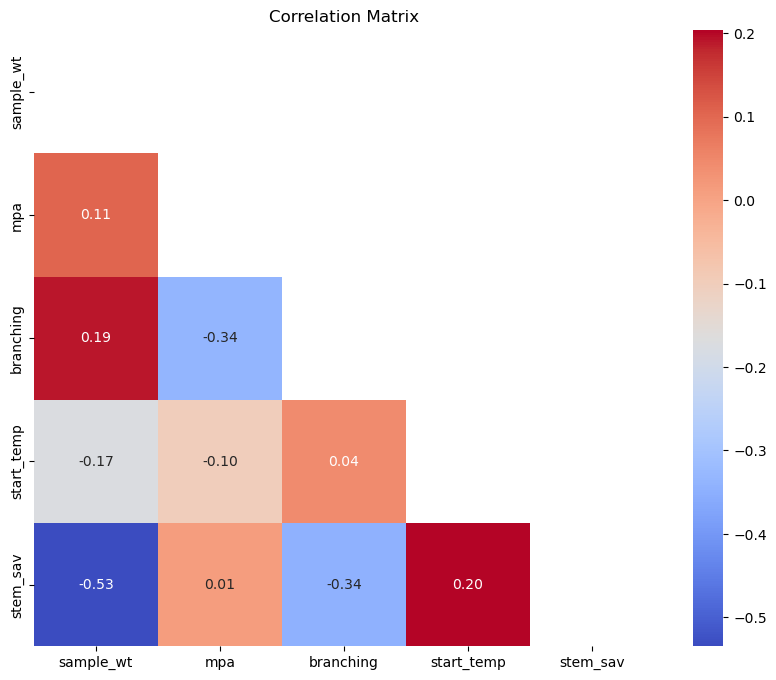

In [11]:
corrplot(flam, ['sample_wt', 'mpa', 'branching','start_temp','stem_sav'])

## display all models within 2 AIC

In [12]:
forms = 'fh ~ sample_wt*mpa + branching + start_temp + stem_sav,fh ~ sample_wt*mpa + sample_wt*start_temp + branching + stem_sav,fh ~ sample_wt*mpa + sample_wt*branching + start_temp + stem_sav,fh ~ sample_wt*mpa + branching + start_temp + stem_sav + thickness,fh ~ sample_wt*mpa + lfm + branching + start_temp + stem_sav,fh ~ sample_wt*mpa + branching + start_temp + dmc + stem_sav,fh ~ sample_wt*mpa + LMA + branching + start_temp + stem_sav,fh ~ sample_wt*mpa + branching + start_temp + stem_sav + leaf_sav,fh ~ sample_wt*mpa + branching + start_temp + branch_volume + stem_sav,fh ~ sample_wt + branching + mpa + start_temp + stem_sav,fh ~ sample_wt + branching + mpa + start_temp + stem_sav + thickness,fh ~ LMA + sample_wt + branching + mpa + start_temp + stem_sav,fh ~ sample_wt + branching + mpa + start_temp + branch_volume + stem_sav,fh ~ sample_wt + branching + mpa + start_temp + stem_sav + leaf_sav'

aics = []
bics = []
vifs = []

formlist = forms.split(',')
for formula in formlist:
    # check VIF
    b = formula.split(' ')
    c = [x.split('*') for x in b]
    d = [j for i in c for j in i]
    e = [x for x in d if len(x)>1]
    e.remove(y)
    X = flam[e] 
    vifs.append(round(max([variance_inflation_factor(X.values, i) for i in range(len(X.columns))]),2))
    
    # model
    model = smf.mixedlm(formula, data=flam, groups=flam["species"], re_formula='1', vc_formula={'C(species):C(plant_id)': '0 + C(plant_id)'})
    results = model.fit(reml=False)
    
    # report
    aics.append(round(results.aic,2))
    bics.append(round(results.bic,2))

summary_tab = pd.DataFrame({
    'Formula':formlist,
    'AIC':aics,
    'BIC':bics,
    'VIF':vifs
})

topmods = summary_tab[summary_tab.AIC<=min(summary_tab.AIC+2)].sort_values('AIC').reset_index()
topmods.to_csv('/Users/kristinafauss/BackupToBox/Git/lab-flammability-testing-2022/python-nb-outputs/fh_topmods.csv')
topmods

,index,Formula,AIC,BIC,VIF
0,0,fh ~ sample_wt*mpa + branching + start_temp + ...,293.09,323.71,1.58
1,3,fh ~ sample_wt*mpa + branching + start_temp + ...,293.76,327.45,1.88
2,4,fh ~ sample_wt*mpa + lfm + branching + start_t...,294.33,328.02,2.39
3,7,fh ~ sample_wt*mpa + branching + start_temp + ...,294.49,328.18,1.95
4,6,fh ~ sample_wt*mpa + LMA + branching + start_t...,294.58,328.27,2.09
5,9,fh ~ sample_wt + branching + mpa + start_temp ...,294.69,322.25,1.58
6,5,fh ~ sample_wt*mpa + branching + start_temp + ...,295.04,328.73,2.31
7,8,fh ~ sample_wt*mpa + branching + start_temp + ...,295.08,328.77,3.28


## examine candidate formula(s) for publication

Joe’s Model: 299.5
- `fh ~ sample_wt*lfm + branching`

My Model: 293.09 BEST OVERALL
- `fh ~ sample_wt*mpa + branching + start_temp + stem_sav`
- Consistent selection of start_temp, stem_sav, branching, some water variable (mpa, lfm), and ‘some other variable’ (dmc, LMR, LMA, thickness…).
- `sample_wt*mpa` is maintatined for modeling and REMEF purposes, however it should be noted that the AIC for `sample_wt + branching + mpa + start_temp + stem_sav` is indistinguishable and the models are very similar. The relationships for the interaction terms individually and FH may be interpreted and trusted.

Is there justification to add the new terms `start_temp` & `stem_sav`? Or any others?
- AIC got significantly worse without `start_temp` &/or `stem_sav`

Is there a justification to use any of the other terms which show up in top models?
- `thickness`, `lfm`, `leaf_sav`, `LMA`, `leaf_mass_ratio`, `dmc`, `branch_volume`
- *Examining the models that include these terms - these terms are not significant in those models, though the original terms generally remain significant - they are the strongest predictors.*
- Adding `lfm` or swapping it with `mpa` did not improve the model
- No improvement from adding any of the above terms. Even those which did not significantly worsen the model had dubious coef's (clearly not sig)

AIC: 294.69153676176666
BIC: 322.25489205900936
[1.0, 1.5507787285698828e-14, 0.05505639171163089, 0.3250502148667046, 0.04632366495830592, 0.00013550069306968044, nan, 0.22781080143317642]


<class 'statsmodels.iolib.summary2.Summary'>
"""
                Mixed Linear Model Regression Results
=====================================================================
Model:                  MixedLM     Dependent Variable:     fh       
No. Observations:       158         Method:                 ML       
No. Groups:             7           Scale:                  0.2476   
Min. group size:        8           Log-Likelihood:         -138.3458
Max. group size:        37          Converged:              Yes      
Mean group size:        22.6                                         
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   0.058    0.070  0.839 0.402 -0.078  0.195
sample_wt                   0.525    0.066  7.945 0.000  0.395  0.654
branching                   0.150    0.055  2.702 0.007  0.041  0.258
mpa                        -0.121    0.059 -2.047 0.041 -0.237 -0.005
start_temp                  0.163    0.059  2.759 0.006  0.047  0.279
stem_sav                   -0.316    0.073 -4.302 0.000 -0.460 -0.172
Group Var                   0.000                                    
C(species):C(plant_id) Var  0.145    0.133                           
=====================================================================

"""

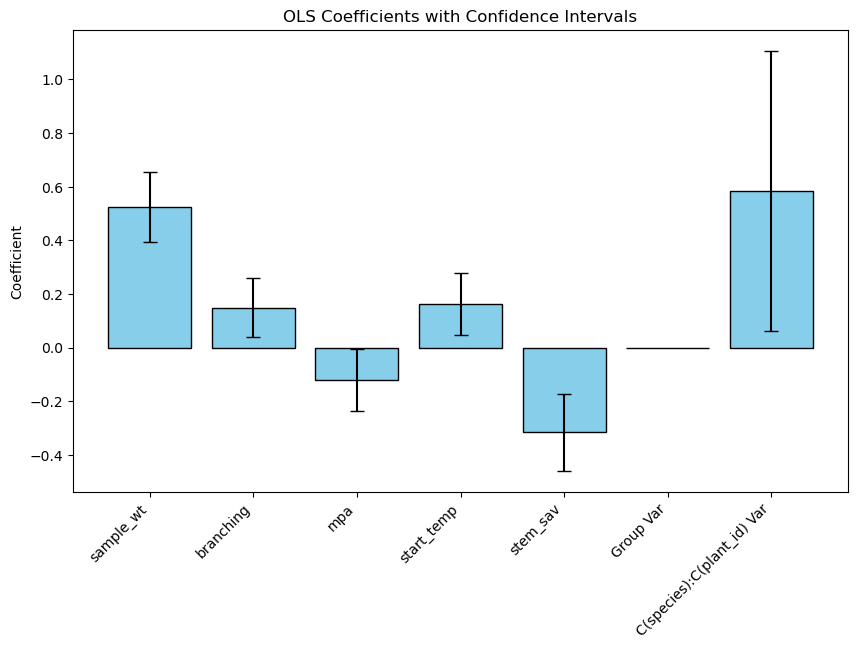

In [37]:
formula = y + '~  sample_wt + branching + mpa + start_temp + stem_sav'

# # check VIF
# X = flam[['sample_wt', 'mpa', 'branching','start_temp','stem_sav']] 
# print('VIFmax:', max([variance_inflation_factor(X.values, i) for i in range(len(X.columns))]))

# model
model = smf.mixedlm(formula, data=flam, groups=flam["species"], re_formula='1', vc_formula={'C(species):C(plant_id)': '0 + C(plant_id)'})
results = model.fit(reml=False)

# report
plot_ols_coefficients(results)
print('AIC:', results.aic)
print('BIC:', results.bic)
# print adjusted pvals
print([i for i in multipletests(results.pvalues, method='bonferroni')[1]])
results.summary()

## interpretation of candidate model

`fh ~ sample_wt + mpa + branching + start_temp + stem_sav`

- FH increases with increasing mass, droughtedness, branchiness, start temp
- FH increases with decreasing stem sav

The 1st order relationships generally make sense:
**Larger flames with thinner stems and larger samples make sense at this scale.** Thinner stems for our samples likely meant **more herbaceous stems that could be consumed** by flaming ignition **thicker, woodier stems typically did not catch on fire but maybe smoldered later**. At this sampling scale, larger and ***more herbaceous means more material combusting simultaneously = larger flames***.

### within species patterns

- FH inc with sample wt across all spec
- FH appears relatively flat wrt mpa across species
- FH increases clearly w branchiness except for ARCDEN and SALAPI where it clearly decreases
- FH consistently inc to neutral with start temp
- spec had sometimes very different ranges for stem_sav, relationship is negative except for ARCDEN (dubious - low n, tight cluster) and ERIKAR (most herbaceous) - makes sense that [thicker herb stems] or [thinner woody stems] would give higher flame heights

<Axes: xlabel='sample_wt*mpa', ylabel='fh'>

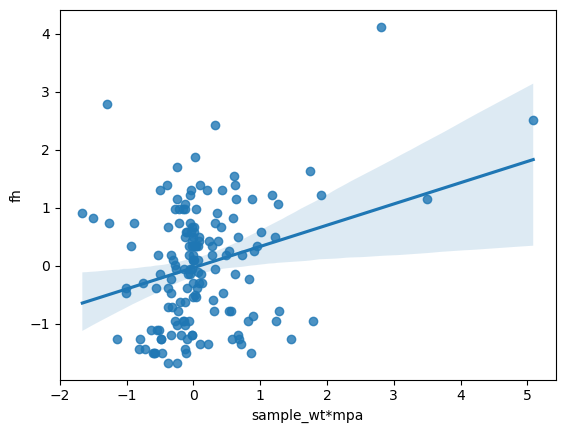

In [27]:
flam['sample_wt*mpa'] = flam.sample_wt*flam.mpa
sns.regplot(x='sample_wt*mpa', y=y, data=flam)#, ci=None, order=2)

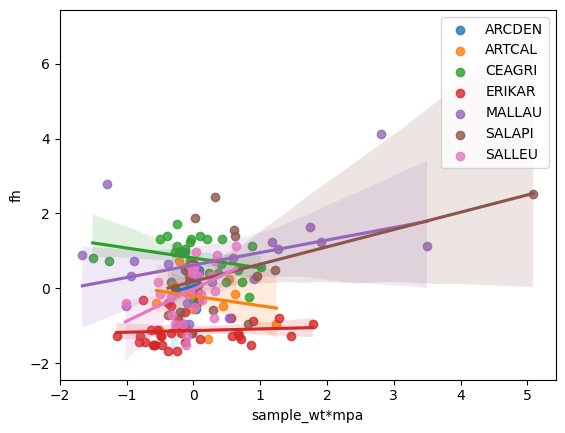

In [26]:
for spec in flam.species.unique():
    flami = flam[flam.species==spec]
    sns.regplot(x='sample_wt*mpa', y=y, data=flami, label=spec)#, ci=None, order=2)
plt.legend()
plt.show();

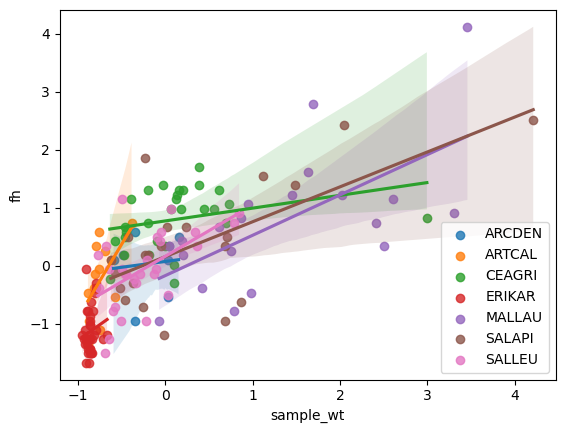

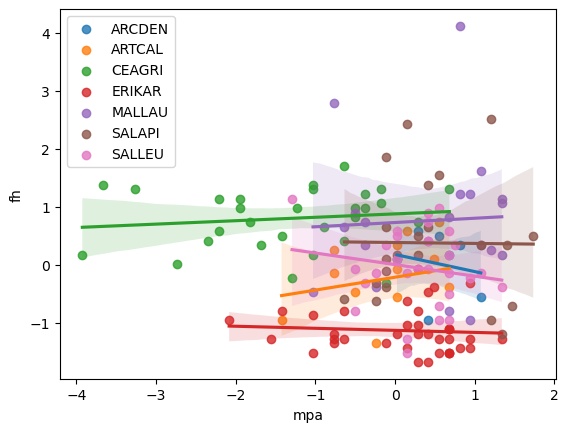

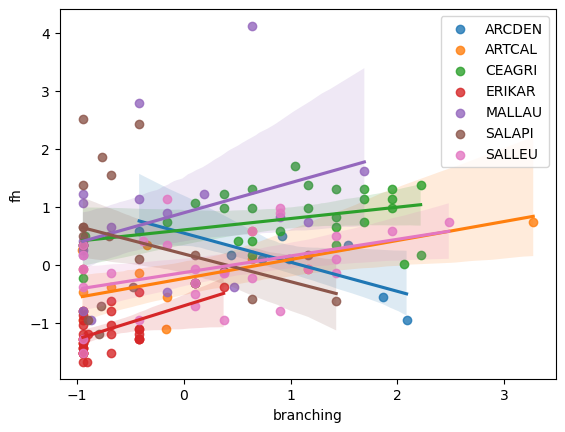

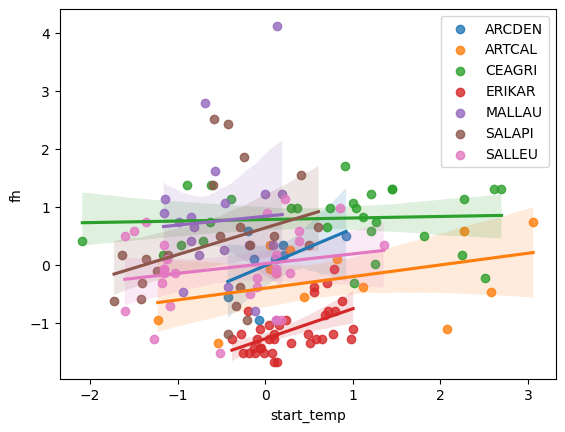

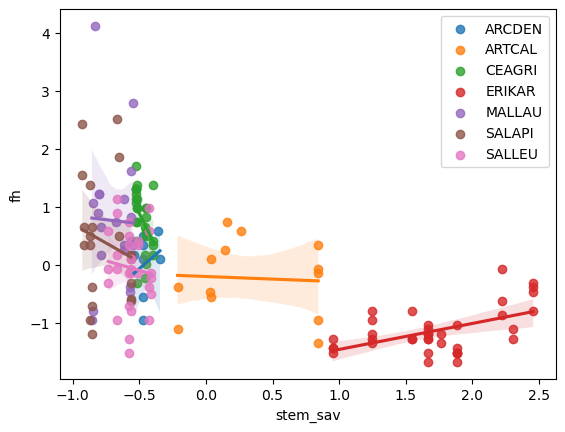

In [19]:
for col in ['sample_wt', 'mpa', 'branching','start_temp','stem_sav']:
    for spec in flam.species.unique():
        flami = flam[flam.species==spec]
        sns.regplot(x=col, y=y, data=flami, label=spec)#, ci=None, order=2)
    plt.legend()
    plt.show();

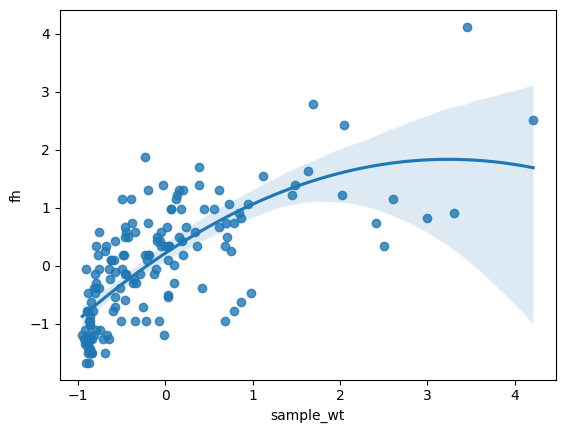

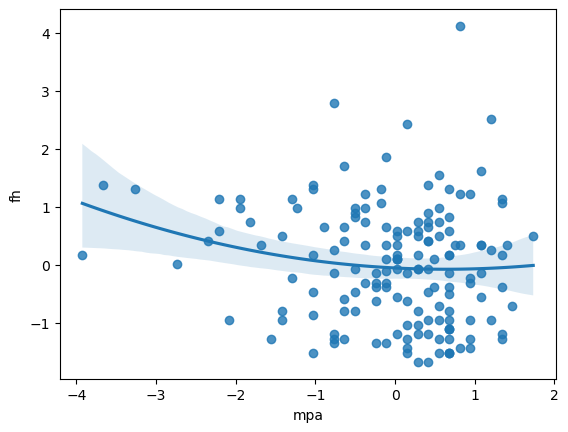

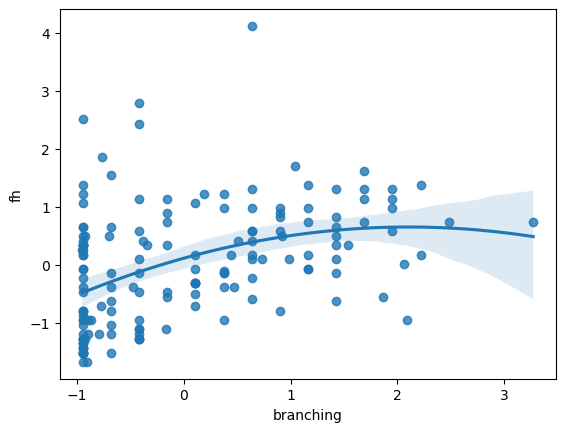

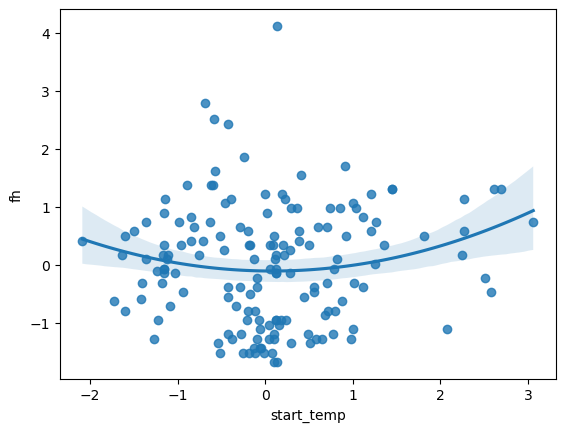

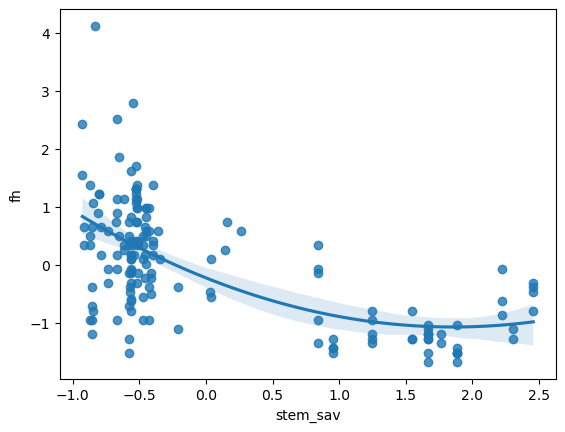

In [15]:
for col in ['sample_wt', 'mpa', 'branching','start_temp','stem_sav']:
    sns.regplot(x=col, y=y, data=flam, order=2)
    plt.show();

In [16]:
pthresh=0.15

for var in ['sample_wt', 'mpa', 'branching','start_temp','stem_sav']:
    print('\n\n', var)
    formula = y + '~' + var
    for spec in flam.species.unique():
        flami=flam[flam.species==spec]
        model = smf.ols(formula, data=flami)
        results = model.fit(reml=False)
        print(spec)
        print(results.params[1], results.pvalues[1])
            #sns.regplot(x= flami.lfm, y= flami.fh);



 sample_wt
ARCDEN
0.2002176904780994 0.7984943945788525
ARTCAL
2.5264213934302164 0.050586297196401335
CEAGRI
0.2202339364725167 0.13021488589705865
ERIKAR
1.0689132935208883 0.36310604528252266
MALLAU
0.6945016946448713 0.0024566481121215157
SALAPI
0.600805065278571 0.0009589117326533063
SALLEU
0.8797797485146656 0.0014578537686728043


 mpa
ARCDEN
-0.2946418535204529 0.6202732898013248
ARTCAL
0.22222899514944852 0.470628409178235
CEAGRI
0.058801240575865554 0.49767770127312716
ERIKAR
-0.035454821473945124 0.6662508584499705
MALLAU
0.0736540560457425 0.8330609244222544
SALAPI
-0.015679683732076594 0.9630984679975363
SALLEU
-0.19939565603041112 0.39736767214595103


 branching
ARCDEN
-0.5015666791807878 0.02403909129023342
ARTCAL
0.32758071460658983 0.02781997227856982
CEAGRI
0.19596147224995267 0.08174697853424004
ERIKAR
0.5737326346517378 0.0032343939424240493
MALLAU
0.5185639598767615 0.11069443537188374
SALAPI
-0.47852042643786086 0.12812315289415907
SALLEU
0.286991871456423 0.02